In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Exploring
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import math 
import wrangle_functions
import env
import acquire
import prepare

In [2]:
############################################################################### ACQUIRE

In [3]:
# use zillow;
# from acquire.py

def new_zillow_data():
    df = pd.read_sql('''SELECT *
    FROM properties_2017
    LEFT OUTER JOIN airconditioningtype 
    USING(airconditioningtypeid) 
    LEFT OUTER JOIN architecturalstyletype
    USING(architecturalstyletypeid) 
    LEFT OUTER JOIN buildingclasstype 
    USING(buildingclasstypeid) 
    LEFT OUTER JOIN heatingorsystemtype
    USING(heatingorsystemtypeid) 
    LEFT OUTER JOIN predictions_2017
    ON predictions_2017.id = properties_2017.id
    INNER JOIN (
    SELECT id, MAX(transactiondate) as last_trans_date 
    FROM predictions_2017
    GROUP BY id
    ) predictions ON predictions.id = properties_2017.id AND predictions_2017.transactiondate = predictions.last_trans_date
    LEFT OUTER JOIN propertylandusetype
    USING(propertylandusetypeid)
      LEFT OUTER JOIN storytype
    USING(storytypeid)
    LEFT OUTER JOIN typeconstructiontype
    USING(typeconstructiontypeid)
    JOIN unique_properties
      ON unique_properties.parcelid = properties_2017.parcelid
    WHERE latitude IS NOT NULL and longitude IS NOT NULL;''', acquire.get_connection('zillow'))
    return df

In [4]:
df = new_zillow_data()

In [5]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,parcelid,basementsqft,...,id,parcelid,logerror,transactiondate,id,last_trans_date,propertylandusedesc,storydesc,typeconstructiondesc,parcelid
0,NaN,NaN,269.00,NaN,NaN,NaN,NaN,0,10754147,NaN,...,0,14297519,0.03,2017-01-01,0,2017-01-01,Planned Unit Development,None,None,10754147
1,NaN,NaN,261.00,NaN,NaN,NaN,NaN,1,10759547,NaN,...,1,17052889,0.06,2017-01-01,1,2017-01-01,Single Family Residential,None,None,10759547
2,NaN,NaN,47.00,NaN,5.00,NaN,NaN,2,10843547,NaN,...,2,14186244,0.01,2017-01-01,2,2017-01-01,Store/Office (Mixed Use),None,None,10843547
3,NaN,NaN,47.00,NaN,3.00,NaN,NaN,3,10859147,NaN,...,3,12177905,-0.10,2017-01-01,3,2017-01-01,Store/Office (Mixed Use),None,None,10859147
4,NaN,NaN,31.00,NaN,4.00,NaN,NaN,4,10879947,NaN,...,4,10887214,0.01,2017-01-01,4,2017-01-01,Commercial/Office/Residential Mixed Used,None,None,10879947


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77614 entries, 0 to 77613
Data columns (total 73 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        166 non-null    float64
 1   storytypeid                   45 non-null     float64
 2   propertylandusetypeid         77614 non-null  float64
 3   heatingorsystemtypeid         48475 non-null  float64
 4   buildingclasstypeid           383 non-null    float64
 5   architecturalstyletypeid      151 non-null    float64
 6   airconditioningtypeid         21457 non-null  float64
 7   id                            77614 non-null  int64  
 8   parcelid                      77614 non-null  int64  
 9   basementsqft                  45 non-null     float64
 10  bathroomcnt                   77614 non-null  float64
 11  bedroomcnt                    77614 non-null  float64
 12  buildingqualitytypeid         50322 non-null  float64
 13  c

In [7]:
df.describe()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,parcelid,basementsqft,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id,parcelid,logerror,id,parcelid
count,166.00,45.00,"77,614.00","48,475.00",383.00,151.00,"21,457.00","77,614.00","77,614.00",45.00,...,"77,614.00","76,003.00","77,103.00","1,505.00","75,519.00","77,614.00","77,614.00","77,614.00","77,614.00","77,614.00"
mean,5.99,7.00,259.94,4.04,3.78,7.43,1.93,"38,806.50","13,379,428.47",593.13,...,"2,016.00","265,047.58","5,371.52",13.91,"60,489,761,355,119.06","38,806.50","13,007,807.98",0.02,"38,806.50","13,379,428.47"
std,0.16,0.00,16.97,3.23,0.46,2.63,3.13,"22,405.38","8,351,447.64",460.92,...,0.07,"528,079.16","10,407.55",1.54,"210,075,285,376.01","22,405.38","3,518,694.35",0.17,"22,405.38","8,351,447.64"
min,4.00,7.00,31.00,1.00,1.00,2.00,1.00,0.00,"10,711,745.00",63.00,...,"2,003.00",4.00,2.54,6.00,"60,371,011,101,000.00",0.00,"10,711,855.00",-4.66,0.00,"10,711,745.00"
25%,6.00,7.00,261.00,2.00,4.00,7.00,1.00,"19,403.25","11,585,723.50",220.00,...,"2,016.00","78,406.50","2,449.60",14.00,"60,373,106,017,007.00","19,403.25","11,538,214.00",-0.02,"19,403.25","11,585,723.50"
50%,6.00,7.00,261.00,2.00,4.00,7.00,1.00,"38,806.50","12,532,247.00",540.00,...,"2,016.00","175,342.00","4,006.66",14.00,"60,375,718,002,010.00","38,806.50","12,530,061.50",0.01,"38,806.50","12,532,247.00"
75%,6.00,7.00,261.00,7.00,4.00,7.00,1.00,"58,209.75","14,115,087.00",732.00,...,"2,016.00","324,677.00","6,198.60",15.00,"60,590,423,262,017.00","58,209.75","14,211,001.25",0.04,"58,209.75","14,115,087.00"
max,6.00,7.00,275.00,24.00,5.00,21.00,13.00,"77,613.00","169,601,949.00","2,443.00",...,"2,016.00","94,011,079.00","1,824,154.85",15.00,"61,110,091,003,005.00","77,613.00","167,689,317.00",5.26,"77,613.00","169,601,949.00"


In [8]:
df.shape

(77614, 73)

In [9]:
df.dtypes

typeconstructiontypeid    float64
storytypeid               float64
propertylandusetypeid     float64
heatingorsystemtypeid     float64
buildingclasstypeid       float64
                           ...   
last_trans_date            object
propertylandusedesc        object
storydesc                  object
typeconstructiondesc       object
parcelid                    int64
Length: 73, dtype: object

In [10]:
# create list of single unit propertylandusedesc
single_prop_types = ['Single Family Residential', 'Condominium', 'Mobile Home',
                     'Manufactured, Modular, Prefabricated Homes', 'Townhouse']
# filter for most-likely single unit properties
df = df[df.propertylandusedesc.isin(single_prop_types)]
df = df[(df.bedroomcnt > 0) & (df.bedroomcnt <= 10)]
df = df[(df.bathroomcnt > 0) & (df.bathroomcnt <= 10)]

In [11]:
wrangle_functions.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
typeconstructiontypeid,67875,99.76
storytypeid,67997,99.94
propertylandusetypeid,0,0.00
heatingorsystemtypeid,22889,33.64
buildingclasstypeid,68041,100.00
...,...,...
last_trans_date,0,0.00
propertylandusedesc,0,0.00
storydesc,67997,99.94
typeconstructiondesc,67875,99.76


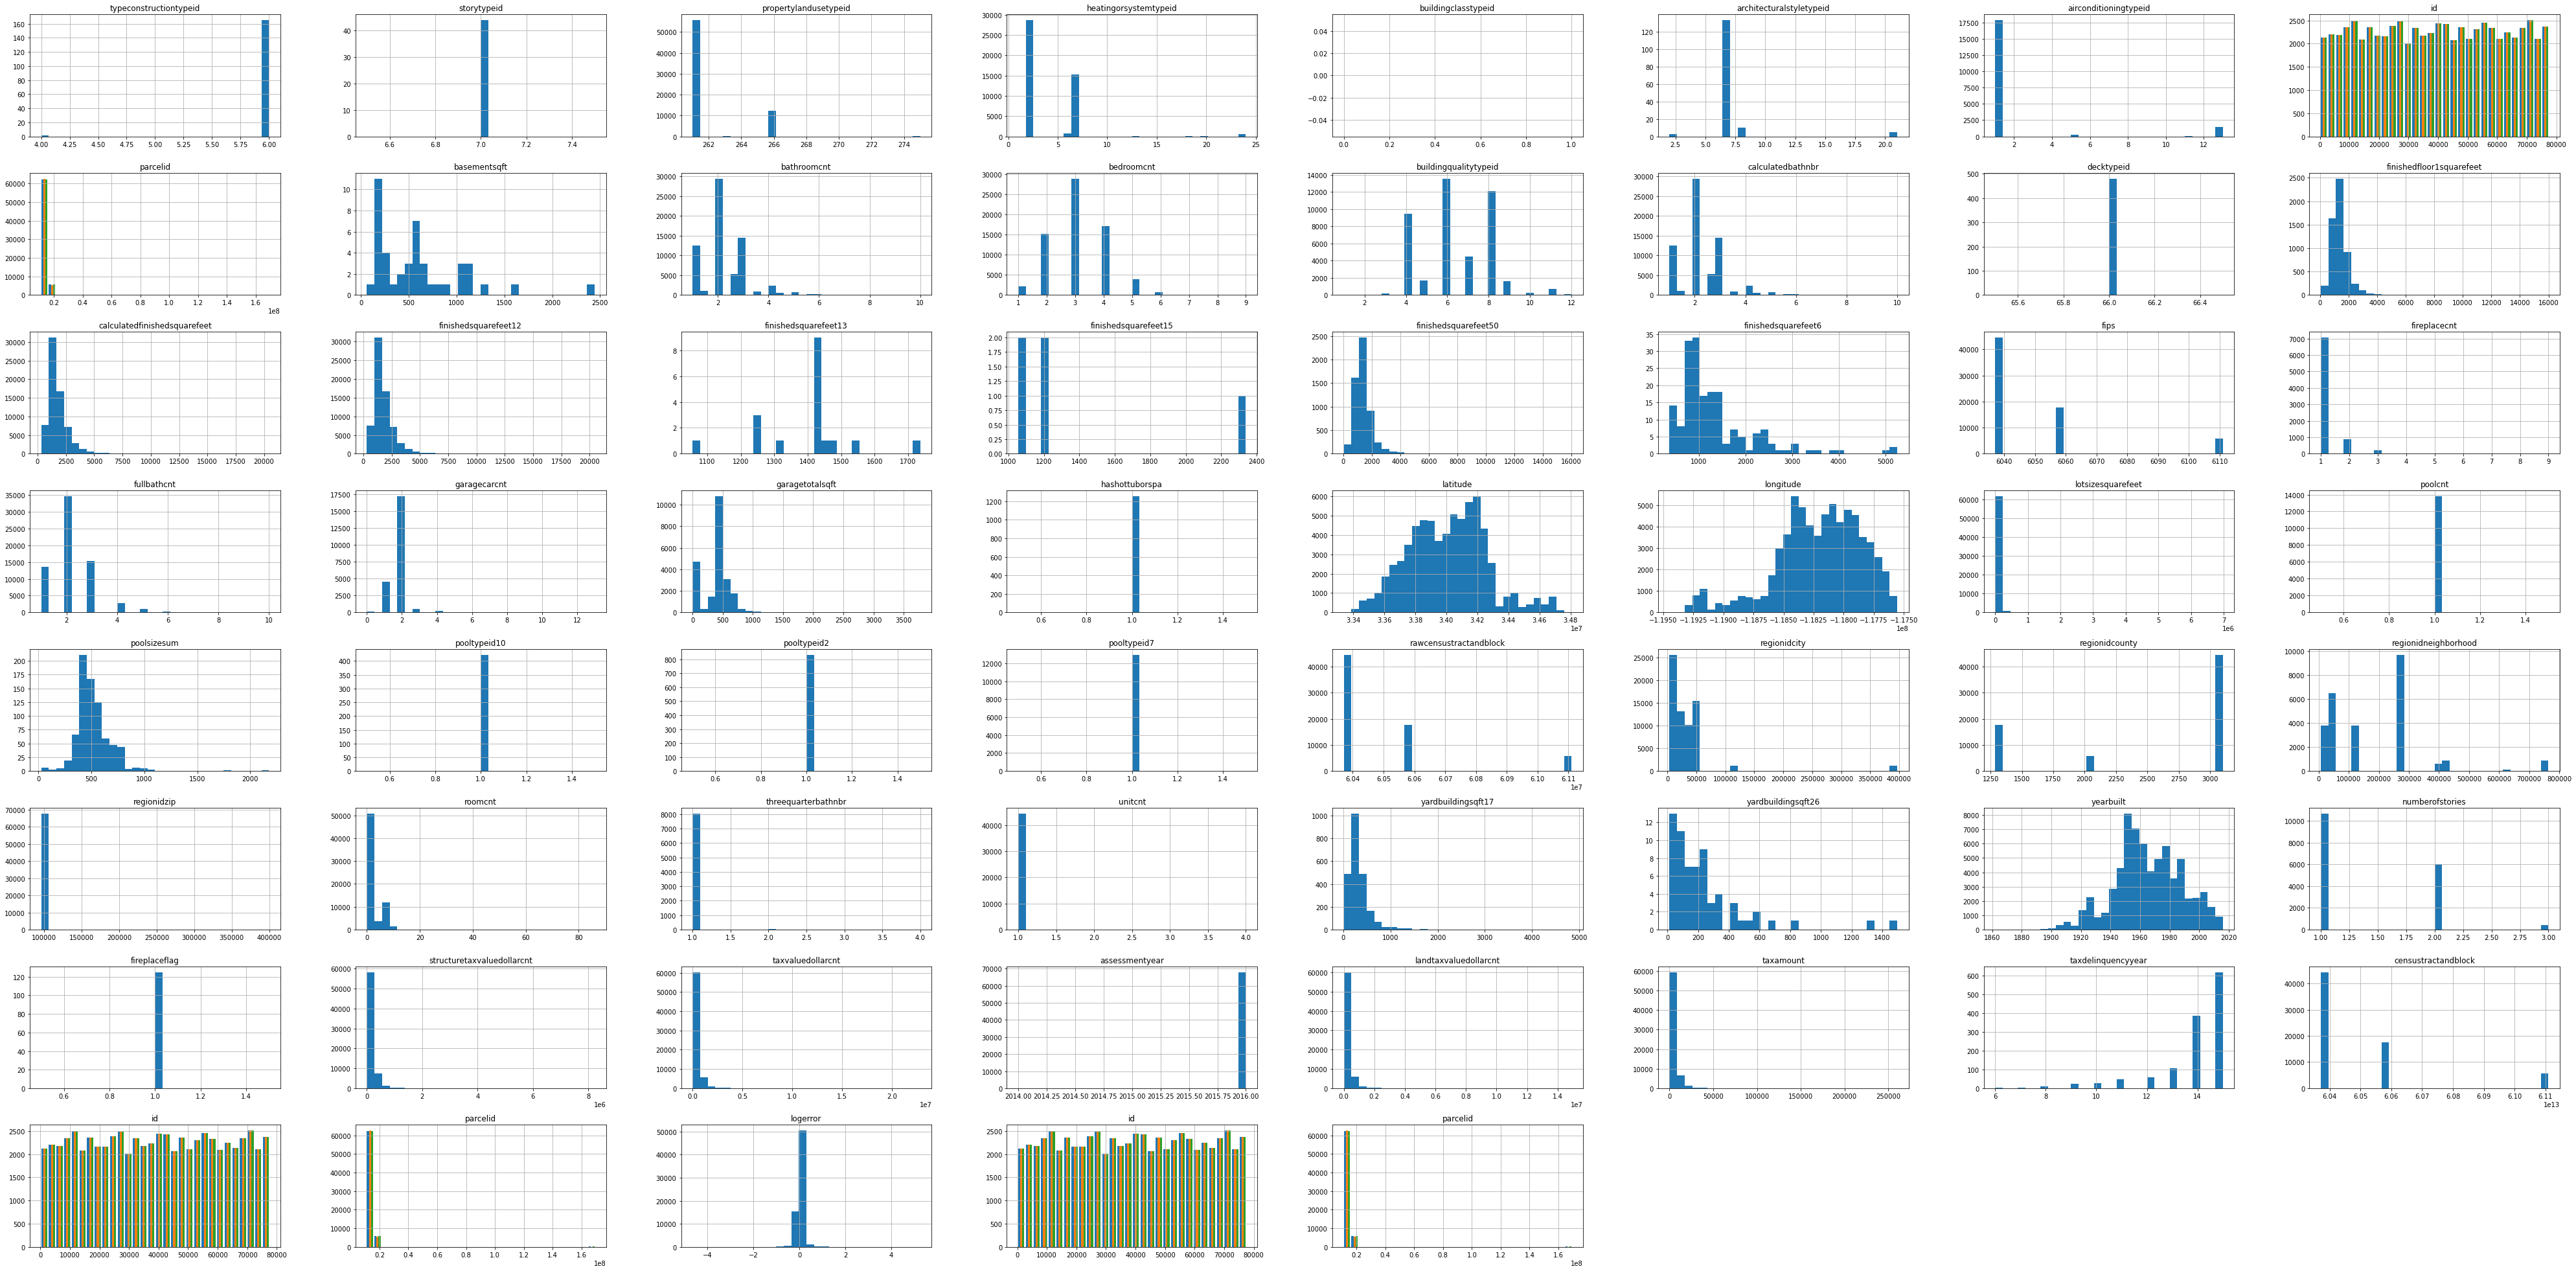

In [12]:
# plot histograms for all variables
df.hist(figsize=(70, 35), bins=30)
plt.show()

********************************************************************* Acquire Takeaways

In [13]:
# how many null values are in each columns 
wrangle_functions.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
typeconstructiontypeid,67875,99.76
storytypeid,67997,99.94
propertylandusetypeid,0,0.00
heatingorsystemtypeid,22889,33.64
buildingclasstypeid,68041,100.00
...,...,...
last_trans_date,0,0.00
propertylandusedesc,0,0.00
storydesc,67997,99.94
typeconstructiondesc,67875,99.76


In [14]:
def drop_cols_null(df, max_missing_rows_pct=0.25):
    '''
    Takes in a DataFrame and a maximum percent for missing values and
    returns the passed DataFrame after removing any colums missing the
    defined max percent or more worth of rows
    '''
    
    # set threshold for axis=1 and drop cols
    thresh_col = math.ceil(df.shape[0] * (1 - max_missing_rows_pct))
    df = df.dropna(axis=1, thresh=thresh_col)

    return df

In [15]:
# I want to drop any column with more than 25% of the values missing
df = drop_cols_null(df)

In [16]:
# the above function removed 39 columns
df.shape

(68041, 34)

In [17]:
df.head()

,propertylandusetypeid,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,taxamount,censustractandblock,id,parcelid,logerror,transactiondate,id,last_trans_date,propertylandusedesc,parcelid
20,261.00,20,11324547,2.00,4.00,2.00,"3,633.00","3,633.00","6,037.00",2.00,...,"6,941.39",NaN,20,12325145,0.04,2017-01-02,20,2017-01-02,Single Family Residential,11324547
30,266.00,30,11524947,2.00,2.00,2.00,"1,090.00","1,090.00","6,037.00",2.00,...,"6,165.36",NaN,30,12713253,0.02,2017-01-02,30,2017-01-02,Condominium,11524947
31,261.00,31,11544747,4.00,3.00,4.00,"1,620.00","1,620.00","6,037.00",4.00,...,"10,244.94",NaN,31,14338242,-0.02,2017-01-02,31,2017-01-02,Single Family Residential,11544747
33,261.00,33,11585547,2.00,3.00,2.00,"2,077.00","2,077.00","6,037.00",2.00,...,"7,924.68",NaN,33,12155445,-0.04,2017-01-02,33,2017-01-02,Single Family Residential,11585547
37,266.00,37,11617547,3.00,2.00,3.00,"2,735.00","2,735.00","6,037.00",3.00,...,"34,982.17",NaN,37,11682477,0.03,2017-01-02,37,2017-01-02,Condominium,11617547


In [18]:
df.columns

Index(['propertylandusetypeid', 'id', 'parcelid', 'bathroomcnt', 'bedroomcnt',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'id', 'parcelid', 'logerror',
       'transactiondate', 'id', 'last_trans_date', 'propertylandusedesc',
       'parcelid'],
      dtype='object')

In [19]:
df =df.drop(columns= ['propertylandusetypeid', 'id', 
       'calculatedbathnbr','rawcensustractandblock',
       'latitude', 'longitude',
        'propertycountylandusecode','regionidcounty','finishedsquarefeet12',
       'regionidzip', 'yearbuilt','id','censustractandblock','last_trans_date',
       'transactiondate', 'id','roomcnt','fullbathcnt','assessmentyear','propertylandusedesc'])


In [20]:
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'lotsizesquarefeet', 'regionidcity',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'parcelid', 'logerror',
       'parcelid'],
      dtype='object')

In [21]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,parcelid,logerror,parcelid
20,11324547,2.00,4.00,"3,633.00","6,037.00","9,826.00","40,227.00","222,321.00","296,425.00","74,104.00","6,941.39",12325145,0.04,11324547
30,11524947,2.00,2.00,"1,090.00","6,037.00","40,247.00","12,447.00","232,897.00","357,568.00","124,671.00","6,165.36",12713253,0.02,11524947
31,11544747,4.00,3.00,"1,620.00","6,037.00",NaN,"12,447.00","339,532.00","847,770.00","508,238.00","10,244.94",14338242,-0.02,11544747
33,11585547,2.00,3.00,"2,077.00","6,037.00","6,490.00","26,964.00","210,192.00","646,760.00","436,568.00","7,924.68",12155445,-0.04,11585547
37,11617547,3.00,2.00,"2,735.00","6,037.00",NaN,"12,447.00","757,582.00","2,922,104.00","2,164,522.00","34,982.17",11682477,0.03,11617547


In [22]:
#check to see if they have the same values
df.parcelid.nunique()

parcelid    68041
parcelid    67880
parcelid    68041
dtype: int64

In [23]:
# here I am dropping the duplicate parcelid column
df = df.iloc[:,~df.columns.duplicated()]

In [24]:
# checking to make sure that happened
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'lotsizesquarefeet', 'regionidcity',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror'],
      dtype='object')

In [25]:
#rename columns we might keep for better understanding
#df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)
df = df.rename(columns={'bathroomcnt':'bathrooms','bedroomcnt': 'bedrooms','calculatedfinishedsquarefeet':
         'area','fips':'zipcode','lotsizesquarefeet': 'lot_area','taxvaluedollarcnt':'tax_value'})

In [26]:
df.shape

(68041, 12)

In [27]:
df = wrangle_functions.handle_missing_values(df)

In [28]:
df.shape

(68041, 12)

In [29]:
# replace nulls with median values for lot_area
df.lot_area.fillna(7313, inplace = True)

In [30]:
# check for nulls values
df.isna().sum()

parcelid                         0
bathrooms                        0
bedrooms                         0
area                             5
zipcode                          0
lot_area                         0
regionidcity                  1237
structuretaxvaluedollarcnt      72
tax_value                        4
landtaxvaluedollarcnt            4
taxamount                       81
logerror                         0
dtype: int64

In [31]:
# drop columns with nulls for yearbuilt, taxvaluedollarcnt and taxamount
df = df.dropna()

In [32]:
# let's check dtypes again now that I have the columns I want
df.dtypes

parcelid                        int64
bathrooms                     float64
bedrooms                      float64
area                          float64
zipcode                       float64
lot_area                      float64
regionidcity                  float64
structuretaxvaluedollarcnt    float64
tax_value                     float64
landtaxvaluedollarcnt         float64
taxamount                     float64
logerror                      float64
dtype: object

In [33]:
# correcting dtype
#df.propertylandusetypeid.astype(object)

In [34]:
# correcting dtype
df.zipcode.astype(object)

20                  6,037.00
30                  6,037.00
31                  6,037.00
33                  6,037.00
37                  6,037.00
                ...         
77609               6,037.00
77610               6,037.00
77611               6,037.00
77612               6,037.00
77613               6,037.00
Name: zipcode, Length: 66703, dtype: object

In [35]:
# correcting dtype
#df.regionidcounty.astype(object)

In [36]:
# I looked up the the average home size is 2,300 sqft so I will make that the cutoff 
# between a large and small home
# here I want to divide the homes and insert into a column those that are more than 2,300 sqft
df['large_home'] =(df['area']> 2300).astype(int)

In [37]:
df.large_home.value_counts()

0    54253
1    12450
Name: large_home, dtype: int64

In [38]:
# check and change dtypes for each column
df.dtypes

parcelid                        int64
bathrooms                     float64
bedrooms                      float64
area                          float64
zipcode                       float64
lot_area                      float64
regionidcity                  float64
structuretaxvaluedollarcnt    float64
tax_value                     float64
landtaxvaluedollarcnt         float64
taxamount                     float64
logerror                      float64
large_home                      int64
dtype: object

In [39]:
df.shape

(66703, 13)

In [40]:
#drop propertylanusetypeid, parcelid, propertylandusedesc, landtaxvaluedollarcnt,structuretaxvaluedollarcnt
df.drop(columns = ['parcelid','landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt'])

,bathrooms,bedrooms,area,zipcode,lot_area,regionidcity,tax_value,taxamount,logerror,large_home
20,2.00,4.00,"3,633.00","6,037.00","9,826.00","40,227.00","296,425.00","6,941.39",0.04,1
30,2.00,2.00,"1,090.00","6,037.00","40,247.00","12,447.00","357,568.00","6,165.36",0.02,0
31,4.00,3.00,"1,620.00","6,037.00","7,313.00","12,447.00","847,770.00","10,244.94",-0.02,0
33,2.00,3.00,"2,077.00","6,037.00","6,490.00","26,964.00","646,760.00","7,924.68",-0.04,0
37,3.00,2.00,"2,735.00","6,037.00","7,313.00","12,447.00","2,922,104.00","34,982.17",0.03,1
...,...,...,...,...,...,...,...,...,...,...
77609,3.00,4.00,"1,921.00","6,037.00","6,763.00","40,227.00","162,019.00","2,860.33",0.02,0
77610,3.00,4.00,"1,780.00","6,037.00","6,822.00","40,227.00","125,923.00","2,394.26",0.01,0
77611,2.00,3.00,"1,549.00","6,037.00","6,987.00","40,227.00","198,988.00","3,331.81",0.04,0
77612,3.00,3.00,"1,339.00","6,037.00","271,458.00","40,227.00","148,600.00","2,510.53",0.01,0


In [41]:
# remove duplicate entries
# sorting by first name
df.sort_values("parcelid", inplace=True)
 
# dropping duplicate values
df.drop_duplicates(keep=False,inplace=True)

In [42]:
# this shows me there were no existing duplicates
df.shape

(66703, 13)

In [43]:
# Columns to look for extreme outliers, taxx_value and area
df = df[df.tax_value < 5_000_000]
df = df[df.area < 8000]

In [44]:
# now I want to make a df with no outliers in any column for 
# comparison in exploration
def outlier_function(df,cols, k):
#function to detect and handle oulier using IQR rule
    df_out = pd.DataFrame()
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr
        new_data = df[(df[col] > upper_bound) | (df[col] < lower_bound)]
        missing_index = new_data.index.difference(df_out.index)
        df_out = df_out.append(new_data.loc[missing_index, : ])
    return df_out

In [45]:
df_out = outlier_function(df,df.columns,.1)

In [46]:
df_out.head()

,parcelid,bathrooms,bedrooms,area,zipcode,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,logerror,large_home
260,14459947,2.00,2.00,"1,970.00","6,059.00","3,856.00","15,554.00","276,693.00","637,686.00","360,993.00","9,729.72",-0.17,0
261,14460147,3.00,4.00,"2,695.00","6,059.00","4,433.00","33,840.00","453,434.00","871,722.00","418,288.00","14,150.72",0.03,1
267,14609147,2.50,3.00,"1,855.00","6,059.00","7,313.00","24,812.00","259,565.00","480,477.00","220,912.00","5,547.20",-0.01,0
268,14618547,2.50,3.00,"2,052.00","6,059.00","7,313.00","52,650.00","325,542.00","791,214.00","465,672.00","11,581.32",-0.02,0
269,14618747,3.50,3.00,"1,888.00","6,059.00","7,313.00","52,650.00","268,740.00","690,166.00","421,426.00","10,142.48",0.01,0


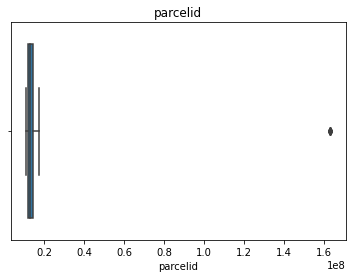

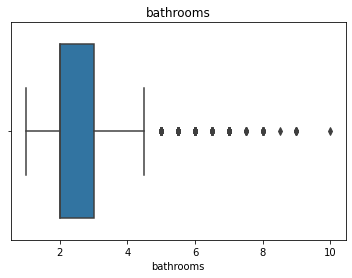

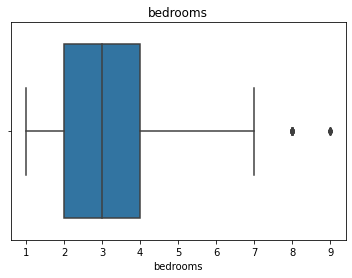

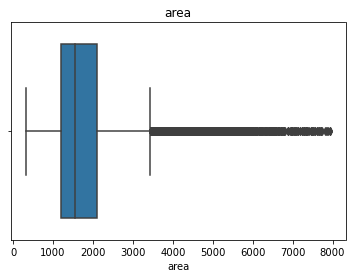

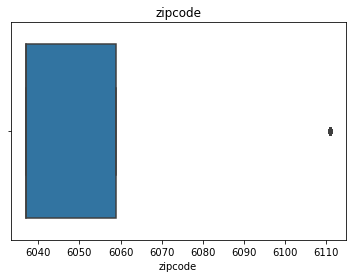

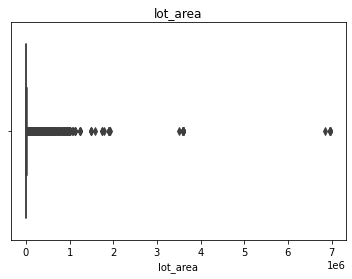

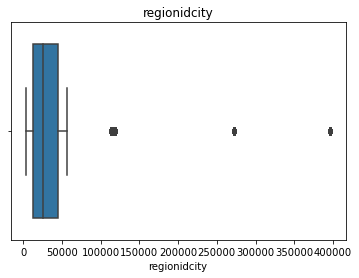

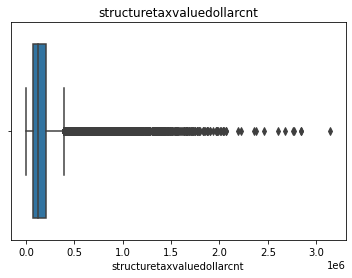

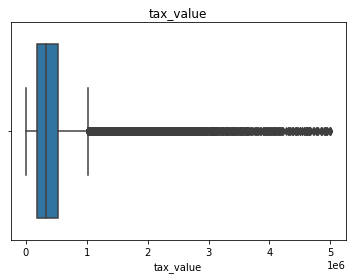

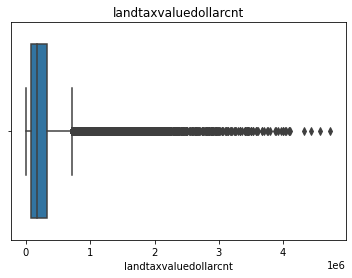

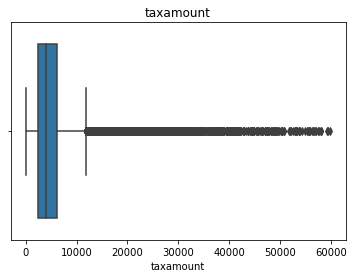

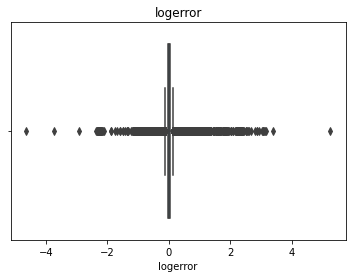

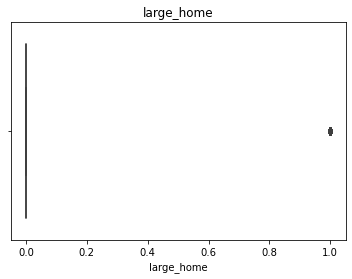

In [47]:
# here are boxplots for all columns with outliers removed
for col in df.columns:
    sns.boxplot(df_out[col])
    plt.title(col)
    plt.show()

In [48]:
df.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'area', 'zipcode', 'lot_area',
       'regionidcity', 'structuretaxvaluedollarcnt', 'tax_value',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'large_home'],
      dtype='object')

In [49]:
#defining the columns to remove outliers from
cols = ['bathrooms', 'bedrooms',
       'area','lot_area','tax_value',
       'taxamount']
k= .1
# create a df with no outliers 
df_no_outs =outlier_function(df,cols, k)

In [50]:
df_no_outs.shape

(53865, 13)

In [51]:
df.shape

(66515, 13)

In [52]:
# time to split the df in prepartion for exploration
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.train_validate_test(df,'logerror')

In [53]:
# I am splitting the df_no_outs into train, test, split but with no outliers
train_no_outs, validate_no_outs, test_no_outs, X_train_no_outs, y_train_no_outs, X_validate_no_outs, y_validate_no_outs, X_test_no_outs, y_test_no_outs = prepare.train_validate_test(df_no_outs,df.logerror)

In [54]:
# # just the regular split of the regular df
# train, validate, test = prepare.train_validate_test(df, 'logerror')

In [55]:
train.head()

,parcelid,bathrooms,bedrooms,area,zipcode,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,logerror,large_home
43359,14340487,4.50,5.00,"4,038.00","6,059.00","11,964.00","27,491.00","570,772.00","1,077,836.00","507,064.00","12,439.58",-0.01,1
28406,14747007,1.00,1.00,726.00,"6,059.00","7,313.00","25,218.00","56,722.00","915,407.00","858,685.00","10,302.96",-0.12,0
63945,11583352,1.00,1.00,865.00,"6,037.00","7,513.00","26,964.00","70,101.00","350,537.00","280,436.00","4,388.57",0.03,0
12623,14437280,3.00,2.00,"1,903.00","6,059.00","12,300.00","13,693.00","237,382.00","641,990.00","404,608.00","6,445.88",-0.21,0
25088,13095063,2.00,4.00,"1,200.00","6,037.00","6,048.00","14,542.00","168,023.00","454,323.00","286,300.00","5,326.98",0.00,0


In [56]:
# now I will create a df that is scaled
_, train_scaled, validate_scaled, test_scaled = wrangle_functions.min_max_scaler(train, validate, test)

In [57]:
train.head()

,parcelid,bathrooms,bedrooms,area,zipcode,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,logerror,large_home
43359,14340487,4.50,5.00,"4,038.00","6,059.00","11,964.00","27,491.00","570,772.00","1,077,836.00","507,064.00","12,439.58",-0.01,1
28406,14747007,1.00,1.00,726.00,"6,059.00","7,313.00","25,218.00","56,722.00","915,407.00","858,685.00","10,302.96",-0.12,0
63945,11583352,1.00,1.00,865.00,"6,037.00","7,513.00","26,964.00","70,101.00","350,537.00","280,436.00","4,388.57",0.03,0
12623,14437280,3.00,2.00,"1,903.00","6,059.00","12,300.00","13,693.00","237,382.00","641,990.00","404,608.00","6,445.88",-0.21,0
25088,13095063,2.00,4.00,"1,200.00","6,037.00","6,048.00","14,542.00","168,023.00","454,323.00","286,300.00","5,326.98",0.00,0


**************************************************************************************** Prepare Takeaways

In [58]:
############################################################################ EXPLORE

The topics of interest I would like to explore are:

    1. Is there a relationship between home lot_area and logerror?
    2. Is there a difference in logerror between small and large houses?(Viz size against logerror -Stats test      to confirm)
    
   

In [59]:
#train.drop(columns=['regionidcounty'])

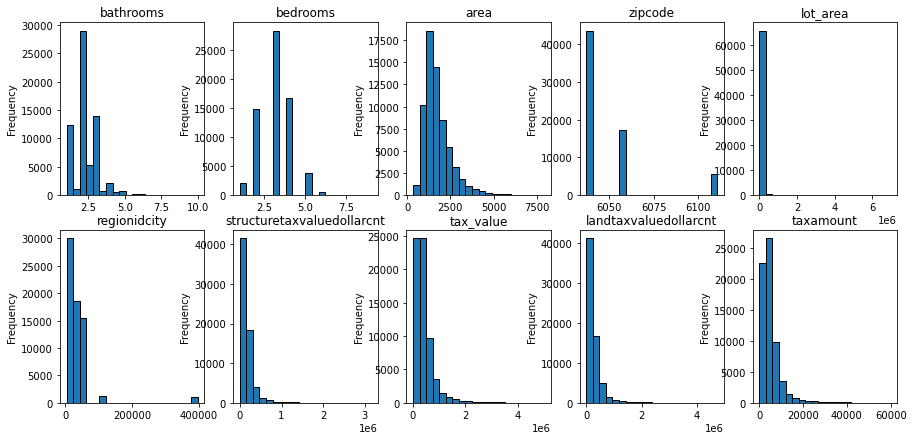

In [60]:
# First let's look at the distribution of each variable
fig, axs = plt.subplots(2, 5, figsize=(15, 7))

for ax, col in zip(axs.flatten(), train.select_dtypes(float)):
    df[col].plot.hist(ax=ax,bins=20, title=col, ec='black')

1. Is there a difference in logerror between small and large houses?(Viz size           against logerror -Stats test to confirm)

In [61]:
# choosing my features
X = train[['area', 'lot_area']]

In [62]:
# same for the scaled X
X_scaled = train_scaled[['area', 'lot_area']]

array([[<AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'lot_area'}>]], dtype=object)

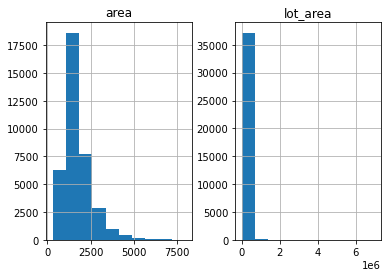

In [63]:
# look at distribution of logerror length and large_home

X.hist()

array([[<AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'lot_area'}>]], dtype=object)

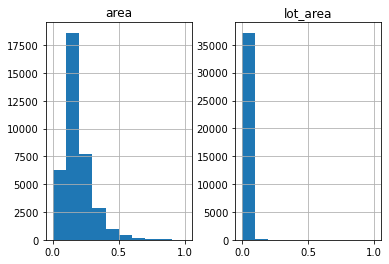

In [64]:
X_scaled.hist()

In [65]:
# sklearn implementation of KMeans

#define it
kmeans_scaled = KMeans(n_clusters=3, random_state=777)

# fit it
kmeans_scaled.fit(X_scaled)

# Use/predict it
kmeans_scaled.predict(X_scaled)

array([0, 1, 1, ..., 2, 1, 2], dtype=int32)

In [66]:
# sklearn implementation of KMeans on unscaled X

#define it
kmeans = KMeans(n_clusters=3, random_state=777)

# fit it
kmeans.fit(X)

# Use/predict it
kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [67]:
# make a new column names cluster in df and X_scaled dataframe and X dataframe
cluster_features = ['area', 'lot_area']
X['cluster'] = kmeans.predict(X[cluster_features])

X['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

X_scaled['cluster'] = kmeans.predict(X[cluster_features])

X_scaled['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

In [68]:
# taking a peek at the unscaled data
X.head()

,area,lot_area,cluster,scaled_cluster
43359,"4,038.00","11,964.00",0,0
28406,726.00,"7,313.00",0,1
63945,865.00,"7,513.00",0,1
12623,"1,903.00","12,300.00",0,2
25088,"1,200.00","6,048.00",0,1


In [69]:
X_scaled.head()

,area,lot_area,cluster,scaled_cluster
43359,0.49,0.00,0,0
28406,0.05,0.00,0,1
63945,0.07,0.00,0,1
12623,0.21,0.00,0,2
25088,0.12,0.00,0,1


In [70]:
centroids = X.groupby('cluster')['area', 'lot_area'].mean()

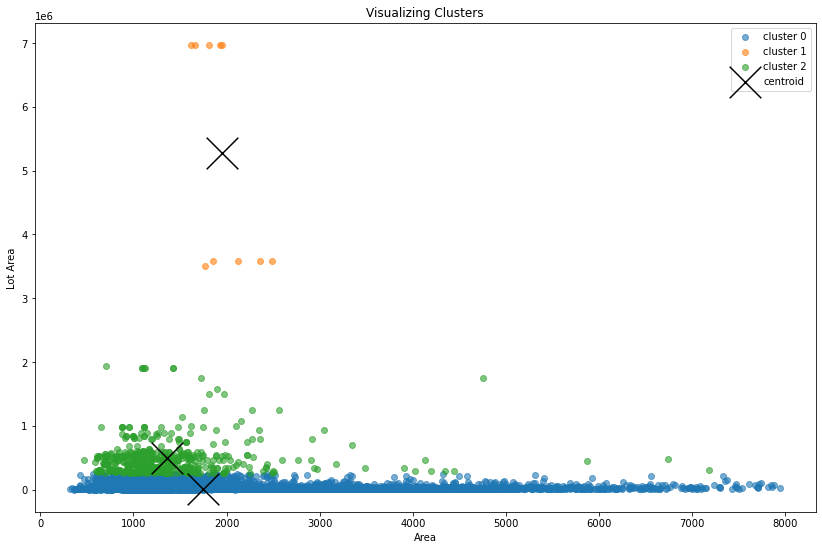

In [71]:
# now I am going to plot the unscaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X.groupby('cluster'):
    plt.scatter(subset.area, subset.lot_area, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='lot_area', x='area', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Area')
plt.ylabel('Lot Area')
plt.title('Visualizing Clusters')
plt.show()

In [72]:
# One column per home size 
# One color/shape for each cluster label
sns.relplot(x="area", y="lot_area", style="cluster", hue="cluster", col="large_home", palette="deep", data=train)

ValueError: Could not interpret value `cluster` for parameter `hue`

In [ ]:
centroids = X_scaled.groupby('scaled_cluster')['area', 'lot_area'].mean()

In [ ]:
# now I am going to plot the unscaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('scaled_cluster'):
    plt.scatter(subset.area, subset.lot_area, label='scaled cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='lot_area', x='area', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Area')
plt.ylabel('Lot Area')
plt.title('Visualizing Clusters Scaled')
plt.show()

In [ ]:
# One column per home size 
# One color/shape for each cluster label
sns.relplot(x="area", y="lot_area", style="cluster", hue="cluster", col="large_home", palette="deep", data=train_scaled)

In [ ]:
train.head()

In [ ]:
train_scaled.head()

In [ ]:
# building a correlation figure
target = train.logerror
def target_heat(df, target, method='pearson'):
    '''
    Use seaborn to create heatmap with coeffecient annotations to
    visualize correlation between all variables
    '''

    # define variable for corr matrix
    heat_churn = train.corr()[target][:-1]
    # set figure size
    fig, ax = plt.subplots(figsize=(30, 1))
    # define cmap for chosen color palette
    cmap = sns.diverging_palette(h_neg=220, h_pos=13, sep=25, as_cmap=True)
    # plot matrix turned to DataFrame
    sns.heatmap(heat_churn.to_frame().T, cmap=cmap, center=0,
                annot=True, fmt=".1g", cbar=False, square=True)
    #  improve readability of xticks, remove churn ytick
    plt.xticks(ha='right', va='top', rotation=35, rotation_mode='anchor')
    plt.yticks(ticks=[])
    # set title and print graphic
    plt.title(f'Correlation to {target}\n')
    plt.show()


In [ ]:
train.columns

In [ ]:
# create heatmap to find any obvious correlations to target
target_heat(train.drop(
    columns=['parcelid','regionidcity','zipcode',
             'tax_value']), 'logerror')

-now I want to perform a pearson r test on logerror and area to check for linear correlation and check the
strength of the correlation
alpha = .05
H0: There is no linear correlation between area and logerror

In [ ]:
test_results = stats.pearsonr(train.lot_area, train.logerror)
test_results

In [ ]:
# the r-value is .0015
# the p-value is very high therefore we must fail to reject the HO and accept that there is no correlations
# between lot_area and logerror

In [ ]:
# next I will explore my 2nd hypothesis
#Is there a differnce in logerror between area of a home (large_home)?

In [ ]:
# here is a violinplot to help us answer that question
sns.violinplot(data=train, y='logerror', x='large_home')

**Takeaways**
the violin chart seems to say yes there is more logerror for larger homes

In [ ]:
# here is a violinplot to help us answer that question this time with no outliers
sns.violinplot(data=train_no_outs, y='logerror', x='large_home')

**Takeaways**
without the outliers it looks like there is more logerror in small homes
considering the plot above this with outliers I can't come to any conclusion

In [ ]:
# now let's look at it with a boxplot
sns.boxplot(data=train, y='logerror', x='large_home')
plt.title("Is there a difference in logerror for large homes?")

**Takeaway**
I can't see any significant difference in logerror between the small and large homes

In [ ]:
# now let's look at it with a boxplot with no outliers
sns.boxplot(data=train_no_outs, y='logerror', x='large_home')
plt.title("Is there a difference in logerror for large homes?")

**Takeaway**
I can't see any significant difference in logerror between the small and large homes

In [ ]:
#let's try a barplot to visualize the difference
sns.barplot(data=train, y='logerror', x='large_home')

**Takeaways**
There is higher logerror in large homes

In [ ]:
#let's try a barplot to visualize the difference
sns.barplot(data=train_no_outs, y='logerror', x='large_home')

**Takeaways**
There is slightly higher logerror in large homes even when outliers are romoved

alpha= .05
HO: There is no difference in logerror between large and small homes.
HA: There is a difference in logerror between large and small homes.

In [ ]:
# I am going to use a Pearson R test because I will compare two continuous values, logerror and area
test_results = stats.pearsonr(train.area, train.logerror)
test_results

In [ ]:
# the test statistic r at -0.00016509 shows these two are NOT strongly inversely correlated
# the p value is way above the alpha so we fail to reject the HO
# There is no significant difference betweeen logerror in large homes compared to small homes.

In [ ]:
# Scale the datasets
scaler = MinMaxScaler()
cols = train.drop(columns=["logerror"]).columns.tolist()

# .copy() makes a copy
# this is an alternative to wrapping the scaled numpy array in a pd.Dataframe()
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

# apply our scaler (fit only on train!)
train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.transform(validate[cols])
test_scaled[cols] = scaler.transform(test[cols])

In [ ]:
train_scaled.head()

In [ ]:
# Fit K-Means 
X = train_scaled[["area", "large_home"]]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

train_scaled['cluster'] = kmeans.predict(X)
train_scaled.head()

In [ ]:
# visualize w/ hue="logerror" style="cluster" with scaled data
sns.relplot(x="large_home", y="area", hue="logerror", col="cluster",palette = 'Purples', data=train_scaled)

In [ ]:
def get_inertia(k):
    return KMeans(k).fit(X).inertia_

plt.figure(figsize=(13, 7))

df = pd.Series([get_inertia(k) for k in range(2, 13)]).plot()

plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 10))
plt.grid()

In [ ]:
train_scaled.columns

In [ ]:
train_scaled.isna().sum()

In [ ]:
# Fit K-Means
X = train_scaled[['bathrooms', 'bedrooms', 'area', 'zipcode', 'lot_area']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

train_scaled['cluster'] = kmeans.labels_

# visualize w/ hue="logerror" style="cluster"
sns.relplot(x="large_home", y="lot_area", hue="logerror", col="cluster", col_wrap=3,palette = "Purples", data=train_scaled)
